# Imports

In [1]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchaudio.transforms as T

import glob
from pathlib import Path

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
    
src_abspath = os.path.abspath('..')

if src_abspath not in sys.path:
    sys.path.append(src_abspath)


In [8]:
from src.forecasters.datasets import NASAIMSRawDataset, NASAIMSSpectrumDataset, NASAIMSMelDataset, get_nasa_stats

# Подгрузка конфига

In [5]:
from hydra import initialize, compose
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    print(cfg)

{'data': {'window_size': 1024, 'overlap': 768, 'spectral': False, 'sample_rate': 20000, 'f_max': 5000, 'n_mels': 64, 'chunk_size': 8192, 'chunk_overlap': 6144}}


In [6]:
DATA_PATH = "../data/2nd_test/"

files = os.listdir(DATA_PATH)
files = sorted(files)

data = pl.read_csv(Path(DATA_PATH) / files[0], has_header=False, separator='\t')

# Dataset example

# Тест датасета на сыром сигнале

Reading files:   0%|          | 0/295 [00:00<?, ?it/s]

Raw Pair Dataset: 295 files, 76 pairs per file.
Raw Pair Dataset: 295 files, 76 pairs per file.
Raw Pair Dataset: 295 files, 76 pairs per file.
Raw Pair Dataset: 295 files, 76 pairs per file.
Raw Pair Dataset: 688 files, 76 pairs per file.
Raw Pair Dataset: 688 files, 76 pairs per file.
Raw Pair Dataset: 688 files, 76 pairs per file.
Raw Pair Dataset: 688 files, 76 pairs per file.


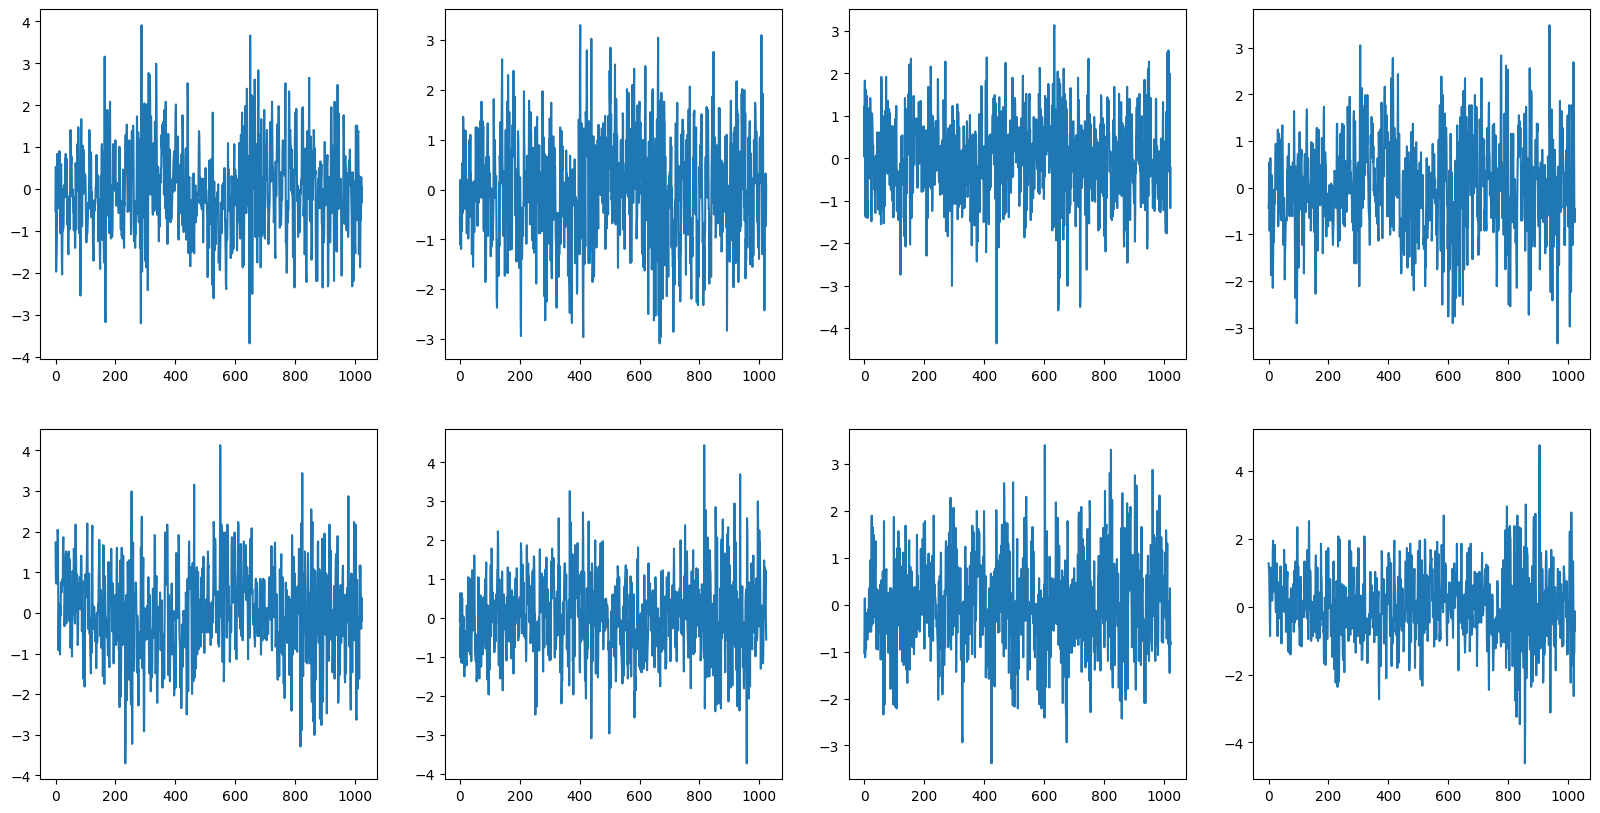

In [10]:
healthy_frac = 0.3
healthy_files = [Path(DATA_PATH) / el for el in files[:int(len(files) * healthy_frac)]]

test_frac = 0.7
test_files = [Path(DATA_PATH) / el for el in files[-int(len(files) * test_frac):]]

z_norm_params = get_nasa_stats(healthy_files)

ds0 = NASAIMSRawDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
ds1 = NASAIMSRawDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
ds2 = NASAIMSRawDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
ds3 = NASAIMSRawDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

test_ds0 = NASAIMSRawDataset(test_files, cfg.data.window_size, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
test_ds1 = NASAIMSRawDataset(test_files, cfg.data.window_size, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
test_ds2 = NASAIMSRawDataset(test_files, cfg.data.window_size, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
test_ds3 = NASAIMSRawDataset(test_files, cfg.data.window_size, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
healthy_idx = np.random.randint(len(ds0))

ax[0][0].plot(ds0[healthy_idx][0].ravel())
ax[0][1].plot(ds1[healthy_idx][0].ravel())
ax[0][2].plot(ds2[healthy_idx][0].ravel())
ax[0][3].plot(ds3[healthy_idx][0].ravel())

test_idx = np.random.randint(len(test_ds0[0]))
ax[1][0].plot(test_ds0[test_idx][1].ravel())
ax[1][1].plot(test_ds1[test_idx][1].ravel())
ax[1][2].plot(test_ds2[test_idx][1].ravel())
ax[1][3].plot(test_ds3[test_idx][1].ravel())

# Тест датасета на спектре сигнала

Reading files:   0%|          | 0/295 [00:00<?, ?it/s]

Spectrum Pair Dataset: 295 files.
Spectrum Pair Dataset: 295 files.
Spectrum Pair Dataset: 295 files.
Spectrum Pair Dataset: 295 files.
Spectrum Pair Dataset: 688 files.
Spectrum Pair Dataset: 688 files.
Spectrum Pair Dataset: 688 files.
Spectrum Pair Dataset: 688 files.


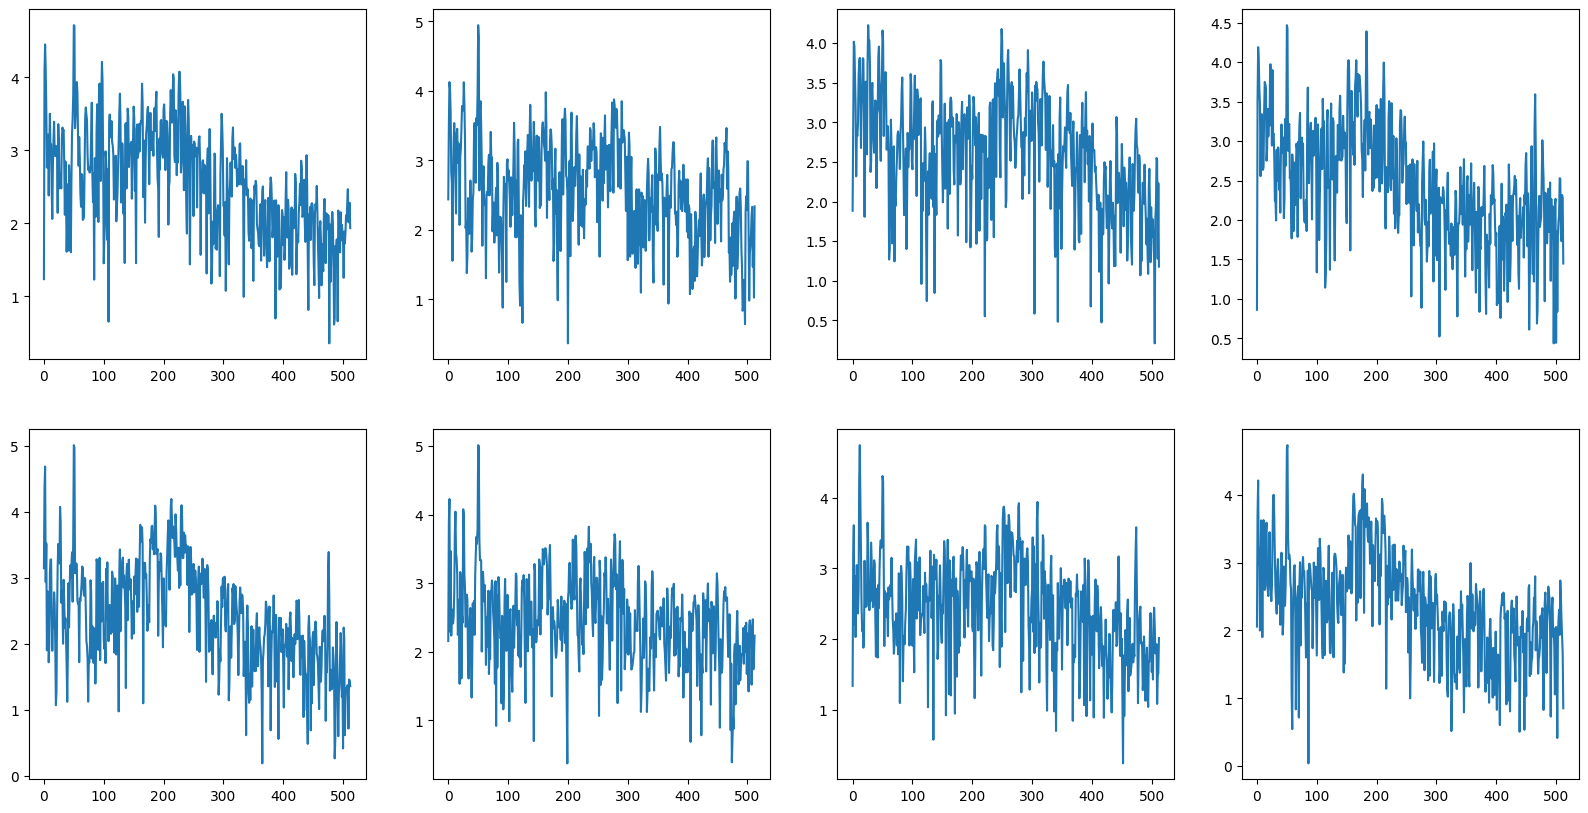

In [11]:
healthy_frac = 0.3
healthy_files = [Path(DATA_PATH) / el for el in files[:int(len(files) * healthy_frac)]]

test_frac = 0.7
test_files = [Path(DATA_PATH) / el for el in files[-int(len(files) * test_frac):]]

z_norm_params = get_nasa_stats(healthy_files)

ds0 = NASAIMSSpectrumDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
ds1 = NASAIMSSpectrumDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
ds2 = NASAIMSSpectrumDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
ds3 = NASAIMSSpectrumDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

test_ds0 = NASAIMSSpectrumDataset(test_files, cfg.data.window_size, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
test_ds1 = NASAIMSSpectrumDataset(test_files, cfg.data.window_size, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
test_ds2 = NASAIMSSpectrumDataset(test_files, cfg.data.window_size, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
test_ds3 = NASAIMSSpectrumDataset(test_files, cfg.data.window_size, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
healthy_idx = np.random.randint(len(ds0))

ax[0][0].plot(ds0[healthy_idx][0].ravel())
ax[0][1].plot(ds1[healthy_idx][0].ravel())
ax[0][2].plot(ds2[healthy_idx][0].ravel())
ax[0][3].plot(ds3[healthy_idx][0].ravel())

test_idx = np.random.randint(len(test_ds0[0]))
ax[1][0].plot(test_ds0[test_idx][1].ravel())
ax[1][1].plot(test_ds1[test_idx][1].ravel())
ax[1][2].plot(test_ds2[test_idx][1].ravel())
ax[1][3].plot(test_ds3[test_idx][1].ravel())

## Тест датасета на спектрограммах

In [12]:
healthy_frac = 0.4
healthy_files = [Path(DATA_PATH) / el for el in files[:int(len(files) * healthy_frac)]]

test_frac = 0.1
test_files = [Path(DATA_PATH) / el for el in files[-int(len(files) * test_frac):]]

z_norm_params = get_nasa_stats(healthy_files)

ds0 = NASAIMSMelDataset(healthy_files, 0, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b1_mean"][0], z_norm_params["b1_std"][0]
                       )
ds1 = NASAIMSMelDataset(healthy_files, 1, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b2_mean"][0], z_norm_params["b2_std"][0]
                       )
ds2 = NASAIMSMelDataset(healthy_files, 2, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b3_mean"][0], z_norm_params["b3_std"][0]
                       )
ds3 = NASAIMSMelDataset(healthy_files, 3, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b4_mean"][0], z_norm_params["b4_std"][0]
                       )

test_ds0 = NASAIMSMelDataset(test_files, 0, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b1_mean"][0], z_norm_params["b1_std"][0]
                       )
test_ds1 = NASAIMSMelDataset(test_files, 1, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b2_mean"][0], z_norm_params["b2_std"][0]
                       )
test_ds2 = NASAIMSMelDataset(test_files, 2, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b3_mean"][0], z_norm_params["b3_std"][0]
                       )
test_ds3 = NASAIMSMelDataset(test_files, 3, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b4_mean"][0], z_norm_params["b4_std"][0]
                       )

Reading files:   0%|          | 0/393 [00:00<?, ?it/s]

Mel Pair Dataset: 393 files, 6 pairs per file.
Mel Pair Dataset: 393 files, 6 pairs per file.
Mel Pair Dataset: 393 files, 6 pairs per file.
Mel Pair Dataset: 393 files, 6 pairs per file.
Mel Pair Dataset: 98 files, 6 pairs per file.
Mel Pair Dataset: 98 files, 6 pairs per file.
Mel Pair Dataset: 98 files, 6 pairs per file.
Mel Pair Dataset: 98 files, 6 pairs per file.


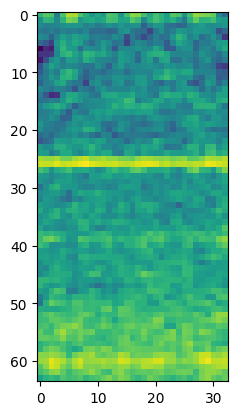

In [14]:
rand_idx = np.random.randint(len(test_ds0))
plt.imshow(ds0[rand_idx][0].permute(1, 2, 0))

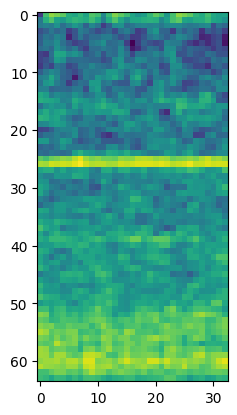

In [15]:
rand_idx = np.random.randint(len(test_ds0))
plt.imshow(ds0[rand_idx][1].permute(1, 2, 0))